[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/YuichiKZ/pytorch_gan/blob/main/Section4_GAN_MNIST_pytorch.ipynb)

#GANのノートブック
- このノートブックではPyTorchによるGANネットワークの実装と学習を行います。

#学習目標
- 画像を生成するGenerator(生成器)のネットワーク構造を理解する
- 画像を識別するDiscriminator(識別器)のネットワーク構造を理解する
- GANの損失関数とニューラルネットワークの学習の流れを理解する
- GANのネットワークを実装できるようにする


# GPU確認

In [ ]:
!nvidia-smi

# PyTorch インポート & バージョン確認

In [ ]:
import torch
import torchvision
# バージョンの確認
print(torch.__version__) 
print(torchvision.__version__) 

# GAN実装

## パッケージインポート

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchsummary

## パラメータ設定

In [ ]:
batch_size=50
z_dim = 100 #ノイズ次元
g_dim = 128 
d_dim = 128 
num_epochs = 20 #エポック数
lr = 0.0002 #学習率
beta1 = 0.5
out_dir = './result_1-VanillaGAN'
loss_display_interval = 600

# 保存先ディレクトリを作成
try:
    os.makedirs(out_dir, exist_ok=True)
except Exception as error: 
    print(error)

# 乱数のシード（種）を固定
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

##データセット定義

- `transforms.Compose(transforms)`
<br>
複数の Transform を連続して行う Transform を作成
- `transforms.ToTensor()`
<br>
PIL Imageまたはnumpy ndarrayをTorch Tensorに変換
- `transforms.Normalize((mean,...),(std,...))`
<br>
各チャンネルに関して標準化を行う<br>
$output[channel] = (input[channel]-mean[channel])/std[channel]$
<br>
i.e. <br>
MNISTの場合<br>
チャンネル数: 1(白黒画像)<br>
分布: [0,1]<br>
より
$std=0.5, mean=0.5$とすると
分布は[-1,1]となる。

In [ ]:
# MNISTの訓練データセットを読み込む
# transforms.ToTensor()-> Torch Tensorに変換
# transforms.Normalize((mean,),(std)) -> テンソルの値を平均mean, 分散stdに変換する
dataset = dset.MNIST(root='./mnist_data', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)) ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
# 画像配列の形状確認
dataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
# 訓練データをセットしたDataLoader作成
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# 学習に使用するデバイスを指定。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda:0


##ネットワークの定義

### Generatorクラス

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, g_dim=128, num_ch=1):
        """
        :z_dim: 入力ベクトルzの次元
        :g_dim: 最終層の入力チャネル数
        :num_ch: 出力画像のチャネル数
        """
        super(Generator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layer = nn.Sequential(
            nn.Linear(z_dim,g_dim*2), #(B,100) -> (B,256) 全結合層
            nn.Linear(g_dim * 2,g_dim * 4), #(B,256) -> (B,512)
            nn.Linear(g_dim * 4,g_dim * 8), #(B,512) -> (B,1024)
            nn.ReLU(),  #活性化関数 relu
            nn.Linear(g_dim * 8,28*28), #(B,1024) -> (B,784)
            nn.Tanh(),  #活性化関数 tanh
        )


    def forward(self, z):
        """
        順方向の演算
        z: 入力ノイズ
        return z: 生成画像
        """
        z = z.view(z.size(0), -1) #(B,100,1,1)->(B,100)
        z = self.layer(z) #(B,100)->(B,28*28)
        z = z.view(-1, 1, 28, 28) #(B,28*28)->(B,1,28,28)
        return z

### Discriminatorクラス

In [ ]:
class Discriminator(nn.Module):
    """
    識別器Dのクラス
    """
    def __init__(self, num_ch=1, d_dim=128):
        """
        :num_ch: 入力画像のチャネル数
        :d_dim: 先頭層の出力チャネル数
        """
        super(Discriminator, self).__init__()

        # ニューラルネットワークの構造を定義する
        self.layer0 = nn.Sequential(
                nn.Linear(28*28, d_dim*4),     # 全結合層
                nn.LeakyReLU(negative_slope=0.2),    # leaky ReLU関数
            )  # (B, 784) -> (B, 512)
        self.layer1 = nn.Sequential(
                nn.Linear(d_dim*4, d_dim * 2),
                nn.LeakyReLU(negative_slope=0.2),
            ) # (B, 512) -> (B, 256)
        self.layer2 = nn.Sequential(
                nn.Linear(d_dim * 2, d_dim),
                nn.LeakyReLU(negative_slope=0.2),
            )  # (B, 256) -> (B, 128)
        self.layer3 = nn.Sequential(
                nn.Linear(d_dim, 1),
                nn.Sigmoid(),    # Sigmoid関数
            )    # (B, 128) -> (B, 1)
        self.layers =[self.layer0,
                      self.layer1,
                      self.layer2,
                      self.layer3]

    def forward(self, x):
        """
        順方向演算
        x: 本物画像または生成画像
        return: 識別信号
        """
        x = x.view(x.size(0), -1) #(B,1,28,28)->(B,784)
        #(B,784)->(B,1)
        for layer in self.layers:  # self.layersの各層で演算を行う
            x = layer(x)
        return x.squeeze()     # Tensorの形状を(B,1)->(B)に変更して戻り値とする

### 重み初期化関数

In [ ]:
def weights_init(m):
    """
    ニューラルネットワークの重みを初期化する。作成したインスタンスに対しapplyメソッドで適用する
    m: ニューラルネットワークを構成する層
    """
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:     # バッチノーマライゼーションの場合
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### 生成器Gのインスタンス生成と重み初期化

In [ ]:
# 生成器G　インスタンス化, GPU上に転送
G = Generator(z_dim=z_dim, g_dim=g_dim).to(device)
G.apply(weights_init)    # weights_init関数で初期化

Generator(
  (layer): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Tanh()
  )
)

### 生成器のTensor形状確認

In [ ]:
# 生成器GのTensor形状
# torchsummary.summary(network, 入力テンソル形状)
# 入力: 100次元のノイズベクトル
torchsummary.summary(G, (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
            Linear-2                  [-1, 512]         131,584
            Linear-3                 [-1, 1024]         525,312
              ReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 784]         803,600
              Tanh-6                  [-1, 784]               0
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 5.67
Estimated Total Size (MB): 5.70
----------------------------------------------------------------


### 識別器Dのインスタンス化と重み初期化

In [ ]:
# 識別器D　インスタンス化, GPU上に転送
D = Discriminator(d_dim=d_dim).to(device)
D.apply(weights_init)

Discriminator(
  (layer0): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer1): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer3): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

### 識別器のTensor形状確認

In [ ]:
# 識別器DのTensor形状
# torchsummary.summary(network, 入力テンソル形状)
# 入力: 1channel*28px*28pxの画像
torchsummary.summary(D, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
         LeakyReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
         LeakyReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
         LeakyReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
           Sigmoid-8                    [-1, 1]               0
Total params: 566,273
Trainable params: 566,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.16
Estimated Total Size (MB): 2.18
----------------------------------------------------------------


## 学習の実行

In [ ]:
criterion = nn.BCELoss()    # バイナリークロスエントロピー

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)  

# オプティマイザの用意
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [ ]:
G_losses = []
D_losses = []

#最初の画像の保存
fake_image = G(fixed_noise)  
vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(out_dir, 0),
                  normalize=True, nrow=10)

# 学習のループ
for epoch in range(num_epochs):
    for n, images in enumerate(dataloader):
        real_image = images[0].to(device)     # 本物画像, GPU上に転送
        sample_size = real_image.size(0)    # 画像枚数
        
        # 標準正規分布(平均0,分散1)からノイズを生成, GPU上に転送
        noise = torch.randn(sample_size, z_dim, 1, 1, device=device)
        # 本物画像に対する正解ラベル:1 , GPU上に転送
        real_target = torch.full((sample_size,), 1., device=device)
        # 生成画像に対する正解ラベル:0 , GPU上に転送
        fake_target = torch.full((sample_size,), 0., device=device)
        
        """
        識別器Dの更新
        """
        D.zero_grad()    # 勾配初期化

        ########################
        # 本物画像に対する損失計算
        ########################
        output = D(real_image) # 識別器Dで本物画像に対する識別信号を出力
        lossD_real = criterion(output, real_target) # 本物画像に対する識別信号の損失値
        D_x = output.mean().item() # 本物画像の識別信号の平均

        ########################
        # 偽物画像に対する損失計算
        ########################
        fake_image = G(noise) # 生成器Gでノイズから生成画像を生成

        output = D(fake_image.detach())  # 識別器Dで本物画像に対する識別信号を出力
        lossD_fake = criterion(output, fake_target)  # 生成画像に対する識別信号の損失値

        ########################
        # 損失計算し,誤差逆伝播
        ########################
        lossD = lossD_real + lossD_fake    # 識別器Dの全体の損失
        lossD.backward()    # 誤差逆伝播
        optimizerD.step()   # Dのパラメーターを更新

        """
        生成器Gの更新
        """
        G.zero_grad()    # 勾配の初期化

        output = D(fake_image)   # 更新した識別器Dで改めて生成画像に対する識別信号を出力
        lossG = criterion(output, real_target)   # 生成器Gの損失値。Dに生成画像を本物画像と誤認させたいため目標値は「1」
        lossG.backward()     # 誤差逆伝播

        optimizerG.step()   # Gのパラメータを更新
        
        """
        DとGのロス表示
        """
        if n % loss_display_interval == 0: 
            print('epoch:[{}/{}],num_images:[{}/{}] Loss_D: {:.3f} Loss_G: {:.3f}'
                  .format(epoch + 1, num_epochs,
                          n + 1, len(dataloader),
                          lossD.item(), lossG.item()))


        if epoch == 0 and n == 0:     # 初回に本物画像を保存する
            vutils.save_image(real_image, '{}/real_samples.png'.format(out_dir),
                              normalize=True, nrow=10)

        # ログ出力用データの保存
        D_losses.append(lossD.item())
        G_losses.append(lossG.item())

    """
    確認用画像の生成
    """
    fake_image = G(fixed_noise)  # 1エポック終了ごとに確認用の生成画像を生成する
    vutils.save_image(fake_image.detach(), '{}/fake_samples_epoch_{:03d}.png'.format(out_dir, epoch + 1),
                      normalize=True, nrow=10)

    """
    モデルの保存
    """
    if (epoch + 1) % 5 == 0:   # 5エポックごとにモデルを保存
        torch.save(G.state_dict(), '{}/G_epoch_{}.pth'.format(out_dir, epoch + 1))
        torch.save(D.state_dict(), '{}/D_epoch_{}.pth'.format(out_dir, epoch + 1))

epoch:[1/20],num_images:[1/1200] Loss_D: 1.387 Loss_G: 0.693
epoch:[1/20],num_images:[601/1200] Loss_D: 0.659 Loss_G: 2.947
epoch:[2/20],num_images:[1/1200] Loss_D: 0.977 Loss_G: 2.949
epoch:[2/20],num_images:[601/1200] Loss_D: 0.668 Loss_G: 1.934
epoch:[3/20],num_images:[1/1200] Loss_D: 0.712 Loss_G: 2.725
epoch:[3/20],num_images:[601/1200] Loss_D: 0.574 Loss_G: 2.207
epoch:[4/20],num_images:[1/1200] Loss_D: 0.938 Loss_G: 1.443
epoch:[4/20],num_images:[601/1200] Loss_D: 0.579 Loss_G: 3.632
epoch:[5/20],num_images:[1/1200] Loss_D: 0.959 Loss_G: 1.645
epoch:[5/20],num_images:[601/1200] Loss_D: 0.922 Loss_G: 1.608
epoch:[6/20],num_images:[1/1200] Loss_D: 0.904 Loss_G: 1.522
epoch:[6/20],num_images:[601/1200] Loss_D: 0.909 Loss_G: 1.769
epoch:[7/20],num_images:[1/1200] Loss_D: 0.951 Loss_G: 1.524
epoch:[7/20],num_images:[601/1200] Loss_D: 1.057 Loss_G: 1.315
epoch:[8/20],num_images:[1/1200] Loss_D: 1.046 Loss_G: 1.879
epoch:[8/20],num_images:[601/1200] Loss_D: 1.111 Loss_G: 0.979
epoch:[9

### 学習済みモデルの推論画像表示

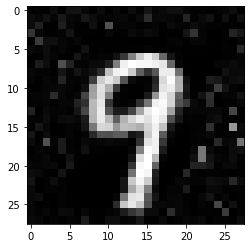

In [86]:
from PIL import Image
# 標準正規分布(平均0,分散1)からノイズを生成, GPU上に転送
noise = torch.randn(sample_size, z_dim, 1, 1, device=device)

fake_image = G(noise) # 生成器Gでノイズから生成画像を生成
fake_image = fake_image.to('cpu').detach() #Pytorch TensorをGPUからCPUに転送
fake_image = fake_image.numpy() #numpy arrayに変換
fake_image = fake_image.squeeze() #(B,C,H,W) -> (B,H,W)に変換

plt.imshow(fake_image[0],cmap='gray')

### 学習時の損失のグラフ表示

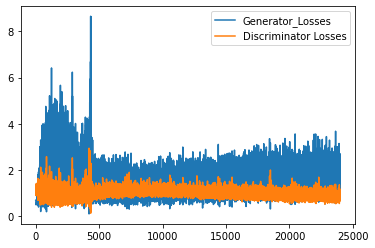

In [87]:
from matplotlib import pyplot as plt

plt.plot(G_losses, label='Generator_Losses')
plt.plot(D_losses, label='Discriminator Losses')
plt.legend()
plt.savefig('loss.png')

### 学習過程のアニメーション

In [88]:
from PIL import Image, ImageDraw

images = []

for epoch in range(num_epochs+1):
  img = Image.open('{}/fake_samples_epoch_{:03d}.png'.format(out_dir, epoch))
  images.append(img)

images[0].save('/content/mnist_gan_animation.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

## 重みのロード & 推論

In [91]:
model_path = os.path.join(out_dir,"G_epoch_10.pth")

# 生成器G　ランダムベクトルから生成画像を作成する
G_infer = Generator(z_dim=z_dim, g_dim=g_dim).to(device)
G_infer.load_state_dict(torch.load(model_path))

# 生成器の画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)  

fake_image = G_infer(fixed_noise)  #確認用の画像を生成する
vutils.save_image(fake_image.detach(), '{}/Generator_sample.png'.format(out_dir),
                  normalize=True, nrow=10)